In [111]:
# general data processing
import pandas as pd
import numpy as np

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import pickle
import os

# pytorch framework
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils

# pytorch-lightning framework
import pytorch_lightning as pl

# Data Loading

'automobile'

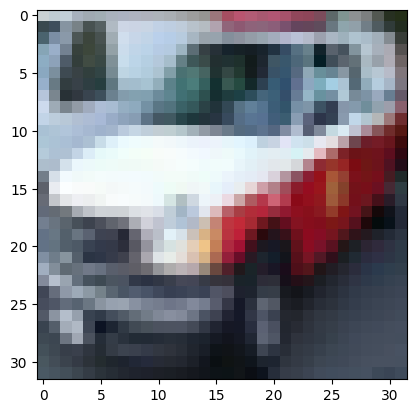

In [154]:
def unpickle(file):
    bytes2str = lambda x: x.decode('utf-8')
    with open(file, 'rb') as fo:
        _dict = pickle.load(fo, encoding='bytes')
    # transform every key from bytes to string in the keys of the dictionary
    _dict = {bytes2str(key): value for key, value in _dict.items()}
    return _dict

def get_label_text(label_idx):
    label_names = unpickle("data/cifar-10-batches-py/batches.meta")['label_names']
    return label_names[label_idx].decode('utf-8')

data = unpickle("data/cifar-10-batches-py/data_batch_1")

IMAGE_INDEX=60
image = torch.Tensor(data["data"]).reshape(10000, 3, 32, 32)
plt.imshow(image[IMAGE_INDEX].permute(1, 2, 0).numpy().astype(np.uint8))
get_label_text(data["labels"][IMAGE_INDEX])

# Data Processing

torch.Size([30, 32, 32, 3])
torch.Size([30, 1])
dog


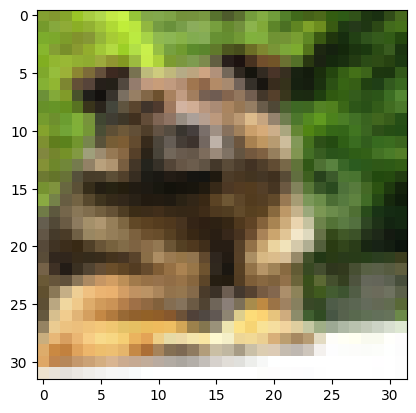

In [156]:
class ToTensor(object):
    def __call__(self, array):
        return torch.from_numpy(array).to(torch.uint8)

class ReshapeAdjust(object):
    def __call__(self, tensor):
        tensor = (
            tensor
            .reshape(3, 32, 32)
            .permute(1, 2, 0)
        )
        return tensor
    
def unpickle(file):
    bytes2str = lambda x: x.decode('utf-8')
    with open(file, 'rb') as fo:
        _dict = pickle.load(fo, encoding='bytes')
    # transform every key from bytes to string in the keys of the dictionary
    _dict = {bytes2str(key): value for key, value in _dict.items()}
    return _dict

class CIFAR10(Dataset):
    def __init__(self, folderpath:str, transform=None, target_transform=None, train=True):
        self.folderpath = folderpath
        full_training_data, test_data = self.get_data_dictionary(self.folderpath)
        self.data = full_training_data if train else test_data
        self.transform = transform
        self.target_transform = target_transform

    @staticmethod
    def get_data_dictionary(folderpath:str) -> tuple:
        full_training_data = {
            "features": [],
            "labels": []
        }
        test_data = {
            "features": [],
            "labels": []
        }
        for file in os.listdir(folderpath):
            if not file.endswith(".meta") and not file.endswith(".html"):
                file = os.path.join(folderpath, file)
                data = unpickle(file)
                data = {key: value for key, value in data.items() if key in ["data", "labels"]}
                if "test" in file:
                    test_data["features"].append(data["data"])
                    test_data["labels"].append(data["labels"])
                else:
                    full_training_data["features"].append(data["data"])
                    full_training_data["labels"].append(data["labels"])
        
        # concatenate all the data
        full_training_data["features"] = np.concatenate(full_training_data["features"])
        full_training_data["labels"] = np.concatenate(full_training_data["labels"]).reshape(-1, 1)

        test_data["features"] = np.concatenate(test_data["features"])
        test_data["labels"] = np.concatenate(test_data["labels"]).reshape(-1, 1)


        return full_training_data, test_data

    def __len__(self) -> int:
        return self.data["labels"].shape[0]
    
    def __getitem__(self, idx:int) -> dict:
        sample = {}

        sample['x'] = self.data["features"][idx]
        sample['y'] = self.data["labels"][idx]

        sample['x'] = self.transform(sample['x']) if self.transform else sample['x']
        sample['y'] = self.target_transform(sample['y']) if self.target_transform else sample['y']

        return sample

class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(
            self,
            folderpath:str, batch_size:int=32, 
            num_workers:int=4, train_val_split:float=0.9, 
            transform=None, target_transform=None
    ):
        super().__init__()
        self.folderpath = folderpath
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_val_split = train_val_split
        self.transform = transform
        self.target_transform = target_transform
    
    def setup(self, stage=None):
        full_training_data = CIFAR10(self.folderpath, self.transform, train=True)
        self.train_dataset, self.val_dataset = random_split(
            full_training_data, [self.train_val_split, 1-self.train_val_split]
        )
        self.test_dataset = CIFAR10(self.folderpath, self.transform, train=False)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

# test datamodule
dm = CIFAR10DataModule(
    "data/cifar-10-batches-py",
    batch_size=30, num_workers=0, train_val_split=0.9,
    transform=transforms.Compose([ToTensor(), ReshapeAdjust()]),
    target_transform=ToTensor()
)
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

# test dataloader
for batch in train_loader:
    print(batch['x'].shape)
    print(batch['y'].shape)
    
    print(get_label_text(batch['y'][0].item()))
    plt.imshow(batch['x'][0].numpy().astype(np.uint8))

    break

# Model Building